Run the cell below if you are using Google Colab to mount your Google Drive in your Colab instance. Adjust the path to the files in your Google Drive as needed if it differs.

If you do not use Google Colab, running the cell will simply do nothing, so do not worry about it.

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd 'drive/My Drive/Colab Notebooks/06_Regression'
except ImportError as e:
    pass

## Exercise 6: Regression

### 6.1. Modeling characteristics of fish
The Fish dataset is a simple dataset which helps to illustrate the linear and non-linear dependencies which may exist between different attributes of the data. The dataset is provided in the fish.csv file. It contains 44 examples, each with four attributes: age, water temperature, weight and length.
#### 6.1.1 Load the Fish dataset and visualize it by combining different attributes. Can you make an assumption about the function to predict the weight and length based on one of the variables?

In [2]:
# Load fish data
import pandas as pd
fish = pd.read_csv('fish.csv')
fish.head()

,age,temp,weight,length
0,14,25,100,620
1,28,25,40,1315
2,41,25,78,2120
3,55,25,99,2600
4,69,25,163,3110


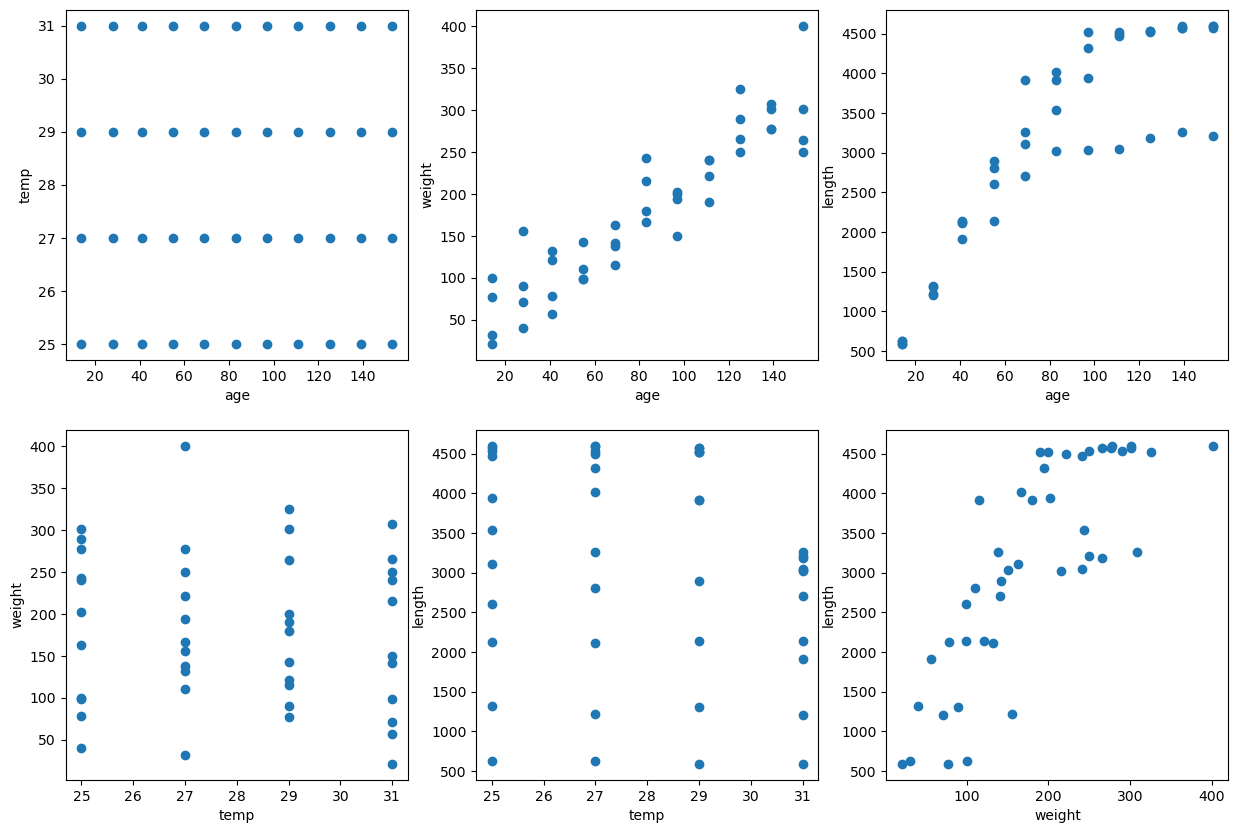

In [3]:
import itertools
import matplotlib.pyplot as plt

# create a list of all columns that we are considering
features = [ 'age', 'temp', 'weight', 'length' ]

# create all combinations of considered columns
combinations = itertools.combinations(features, 2)

# create a figure and specify its size
fig = plt.figure(figsize=(15,10))

# go through all combinations and create one plot for each
figure_index = 1
for combination in combinations:
    # add a sub plot to the figure
    axs = fig.add_subplot(2,3,figure_index)
    
    # plot the feature combination
    axs.scatter(fish[combination[0]], fish[combination[1]])
    
    # set the axis labels of the current sub plot
    axs.set_xlabel(combination[0])
    axs.set_ylabel(combination[1])
        
    # increase the figure index (otherwise all plots are drawn in the first subplot)
    figure_index+=1

    
# show the plot
plt.show()

Answer: We can see a clear linear dependency between the attributes age and weight. There is also a clear non-linear but close to linear dependency between the attributes age and length. By simply looking at these patters in the data, we could infer two things, both of which agree with common sense. First, fish get heavier as they get older, and this does not seem to ever stop. Second, fish get longer with age, but when they reach about 100 days of age, their length starts plateauing.

#### 6.1.2 Learn a linear regression model that predicts the weight of the fish, and another one that predicts the length of the fish based on the combination of attributes you find most convenient for this. Which types of regression work best? Do they apply equally to all combinations of attributes? Make sure to evaluate your results properly!

In [4]:
from sklearn.model_selection import train_test_split

# separate features and target variable
length = fish['length']
weight = fish['weight']

# special case: we only have one feature, so we must reshape the data here
features = fish['age'].values.reshape(-1, 1)

# create a train/test split
length_train, length_test, length_target_train, length_target_test = train_test_split(
    features, length, test_size=0.4, random_state=42)

weight_train, weight_test, weight_target_train, weight_target_test = train_test_split(
    features, weight, test_size=0.4, random_state=42)

We learn a linear regression model for the weight:

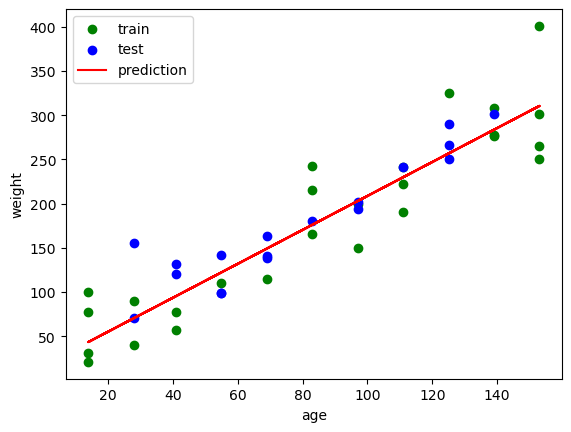

weight = 1.9201086610392863*age + 16.715220383987855


In [5]:
from sklearn.linear_model import LinearRegression

# create and fit a linear regression
weight_estimator = LinearRegression()
weight_estimator.fit(weight_train, weight_target_train)

# plot the original values
plt.scatter(weight_train, weight_target_train, c='green', label='train')
plt.scatter(weight_test, weight_target_test, c='blue', label='test')

# plot the predicted values
plt.plot(fish['age'], weight_estimator.predict(features),c='red', label='prediction')

plt.xlabel('age')
plt.ylabel('weight')
plt.legend()
plt.show()

# print the model that was fitted (the regression formula)
print("weight = {}*age + {}".format(weight_estimator.coef_[0], weight_estimator.intercept_))

We learn a linear regression model for the length:

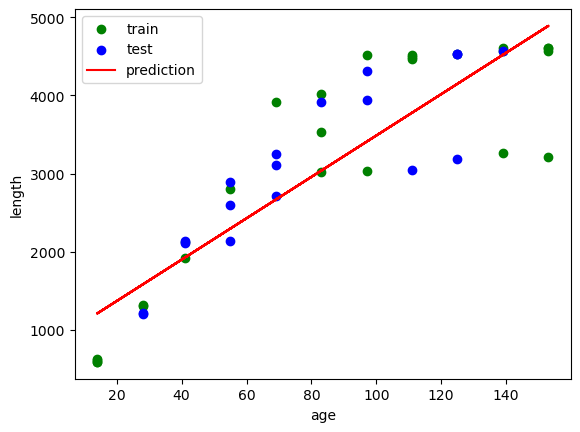

length = 26.458792823864286*age + 840.4859127674263


In [6]:
# create and fit a linear regression
length_estimator = LinearRegression()
length_estimator.fit(length_train, length_target_train)

# plot the original values
plt.scatter(length_train, length_target_train, c='green', label='train')
plt.scatter(length_test, length_target_test, c='blue', label='test')

# plot the predicted values
plt.plot(fish['age'], length_estimator.predict(features),c='red', label='prediction')

plt.xlabel('age')
plt.ylabel('length')
plt.legend()
plt.show()

# print the model that was fitted (the regression formula)
print("length = {}*age + {}".format(length_estimator.coef_[0], length_estimator.intercept_))

We also learn a polynomial regression model for the length:

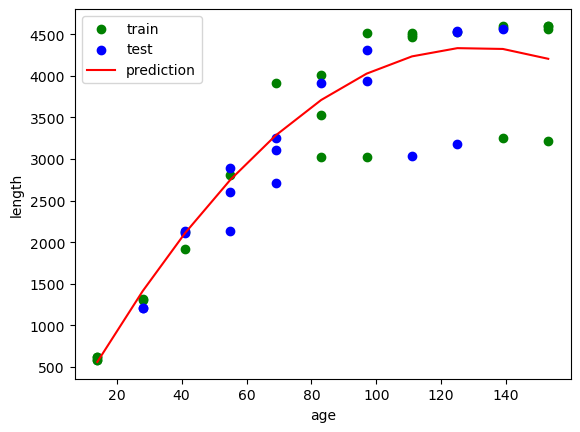

length = 72.5242689018722*age + -0.27733962725136374*age^2 + -399.17576430465397


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# create a transformer that generates polynomial features
transformer = PolynomialFeatures(degree=2, include_bias=False)
estimator = LinearRegression()
pipeline = Pipeline([ ('transformer', transformer), ('estimator', estimator)])
pipeline.fit(length_train, length_target_train)

prediction = pipeline.predict(features)

# plot the original values
plt.scatter(length_train, length_target_train, c='green', label='train')
plt.scatter(length_test, length_target_test, c='blue', label='test')

# create a new dataframe that contains the age and the predictions
d = fish[['age']]
d = d.assign(prediction=prediction)

# sort the data before plotting it
d = d.sort_values(by='age')

# plot the predicted values
plt.plot(d['age'], d['prediction'], c='red', label='prediction')

plt.xlabel('age')
plt.ylabel('length')
plt.legend()
plt.show()

# print the model that was fitted (the regression formula)
print("length = ", end='')
for i, f in enumerate(pipeline.named_steps['transformer'].get_feature_names_out(['age'])):
    if i > 0:
        print(" + ", end='')
    print("{}*{}".format(pipeline.named_steps['estimator'].coef_[i], f), end='')
print(" + {}".format(pipeline.named_steps['estimator'].intercept_))


#### 6.1.3 Measure the performance of the different regression models you learned before. Use 10-fold cross validation and RMSE as well as R² for evaluation.

In [8]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

print("Weight as a function of age")
weight_prediction = cross_val_predict(weight_estimator, features, weight)
mse_1 = mean_squared_error(weight, weight_prediction)
r2_1 = r2_score(weight, weight_prediction)
print("MSE:", mse_1)
print("RMSE:", sqrt(mse_1))
print("R^2:", r2_1)
print()

print("Length as a function of age (linear)")
length_prediction_linear = cross_val_predict(length_estimator, features, length)
mse_2 = mean_squared_error(length, length_prediction_linear)
r2_2 = r2_score(length, length_prediction_linear)
print("MSE:", mse_2)
print("RMSE:", sqrt(mse_2))
print("R^2:", r2_2)
print()

print("Length as a function of age (polynomial)")
length_prediction_polynomial = cross_val_predict(pipeline, features, length)
mse_3 = mean_squared_error(length, length_prediction_polynomial)
r2_3 = r2_score(length, length_prediction_polynomial)
print("MSE:", mse_3)
print("RMSE:", sqrt(mse_3))
print("R^2:", r2_3)
print()

Weight as a function of age
MSE: 1251.1755531820452
RMSE: 35.37195998502267
R^2: 0.8431424793111566

Length as a function of age (linear)
MSE: 523446.5556830205
RMSE: 723.4960647322282
R^2: 0.6967290132690376

Length as a function of age (polynomial)
MSE: 332015.4996629813
RMSE: 576.2078615074436
R^2: 0.807639066300896



We can also learn a model for predicting weight and length using all other features

In [9]:
print("Weight as a function of all other features")
weight_prediction = cross_val_predict(weight_estimator, fish.drop(columns=['weight']), weight)
mse_4 = mean_squared_error(weight, weight_prediction)
r2_4 = r2_score(weight, weight_prediction)
print("MSE:", mse_4)
print("RMSE:", sqrt(mse_4))
print("R^2:", r2_4)
print()

print("Length as a function of all other features")
length_prediction_linear = cross_val_predict(length_estimator, fish.drop(columns=['length']), length)
mse_5 = mean_squared_error(length, length_prediction_linear)
r2_5 = r2_score(length, length_prediction_linear)
print("MSE:", mse_5)
print("RMSE:", sqrt(mse_5))
print("R^2:", r2_5)
print()

Weight as a function of all other features
MSE: 1314.6642128904268
RMSE: 36.258298538271575
R^2: 0.8351830257169851

Length as a function of all other features
MSE: 583951.7868839181
RMSE: 764.1673814577001
R^2: 0.6616738945191628



### 6.2. Feature Selection
In this exercise you will explore different feature selection methods for linear regression.

#### 1. First, fit a linear regression model to the “birthweight_train” dataset without any feature selection and evaluate the model on the “birthweight_test” dataset.

In [10]:
# Load train and test data
b_train = pd.read_csv('birthweight_train.csv', sep=';')
b_test = pd.read_csv('birthweight_test.csv', sep=';')

b_train.head()

,LowBirthWeight = Low,LowBirthWeight = Normal,headcirumference,length,Gestation,smoker,motherage,mnocig,mheight,mppwt,fage,fedyrs,fnocig,fheight,lowbwt,mage35,id,Birthweight
0,0.0,1.0,13.0,19.0,34.0,0.0,26.0,0.0,65.0,140.0,25.0,12.0,25.0,69.0,0.0,0.0,808.0,6.4
1,1.0,0.0,13.0,18.0,35.0,1.0,20.0,35.0,67.0,125.0,23.0,12.0,50.0,73.0,1.0,0.0,516.0,5.8
2,0.0,1.0,13.0,19.0,37.0,0.0,28.0,0.0,62.0,118.0,39.0,10.0,0.0,67.0,0.0,0.0,321.0,6.8
3,0.0,1.0,12.0,19.0,37.0,1.0,19.0,7.0,65.0,132.0,20.0,14.0,0.0,72.0,0.0,0.0,575.0,6.1
4,0.0,1.0,14.0,21.0,38.0,0.0,18.0,0.0,67.0,109.0,20.0,12.0,7.0,67.0,0.0,0.0,1081.0,8.0


In [11]:
# Split features and target

# drop the 'id' and 'Birthweigth' columns from the feature set
# using .iloc[,] you can access parts of the dataframe using numeric indices
# the first argument specifies which records to keep (here : means all)
# the second argument specifies which columns to keep (here 0:-2 means start from the first and end before the second last)
features_train = b_train.iloc[:,0:-2]
target_train = b_train['Birthweight']

features_test = b_test.iloc[:,0:-2]
target_test = b_test['Birthweight']

features_train.head()

,LowBirthWeight = Low,LowBirthWeight = Normal,headcirumference,length,Gestation,smoker,motherage,mnocig,mheight,mppwt,fage,fedyrs,fnocig,fheight,lowbwt,mage35
0,0.0,1.0,13.0,19.0,34.0,0.0,26.0,0.0,65.0,140.0,25.0,12.0,25.0,69.0,0.0,0.0
1,1.0,0.0,13.0,18.0,35.0,1.0,20.0,35.0,67.0,125.0,23.0,12.0,50.0,73.0,1.0,0.0
2,0.0,1.0,13.0,19.0,37.0,0.0,28.0,0.0,62.0,118.0,39.0,10.0,0.0,67.0,0.0,0.0
3,0.0,1.0,12.0,19.0,37.0,1.0,19.0,7.0,65.0,132.0,20.0,14.0,0.0,72.0,0.0,0.0
4,0.0,1.0,14.0,21.0,38.0,0.0,18.0,0.0,67.0,109.0,20.0,12.0,7.0,67.0,0.0,0.0


We start with a standard linear regression model using all the features.

In [12]:
reg = LinearRegression()
reg.fit(features_train, target_train)
mse = mean_squared_error(target_test, reg.predict(features_test))
print("RMSE:", sqrt(mse))

RMSE: 1.059939020622685


In [13]:
from sklearn.linear_model import Ridge
reg = Ridge()
reg.fit(features_train, target_train)
mse = mean_squared_error(target_test, reg.predict(features_test))
print("RMSE:", sqrt(mse))

RMSE: 0.9648433458423221


#### 2. Look at the results of an F-Regression and inspect the p-values for each feature. Fit a second regression model using only the significant features (p<=0.05). How does the performance of your model change?

In [14]:
from sklearn.feature_selection import f_regression

# run the F-Test
f, pval = f_regression(features_train, target_train)

# prepare a dataframe to inspect the results
stat = pd.DataFrame({ 'feature': features_train.columns, 'F value': f, 'p value': pval })
stat['p value'] = round(stat['p value'], 2)
stat = stat.sort_values("p value", ascending=False)
# show the results
display(stat)

,feature,F value,p value
15,mage35,0.001354,0.97
12,fnocig,0.011407,0.92
13,fheight,0.042181,0.84
11,fedyrs,0.062778,0.80
6,motherage,0.195507,0.66
10,fage,0.342294,0.56
5,smoker,1.574123,0.22
9,mppwt,1.818643,0.19
8,mheight,2.087771,0.16
0,LowBirthWeight = Low,2.476791,0.13


In [15]:
from sklearn.feature_selection import SelectKBest, SelectFwe

best = SelectFwe(f_regression, alpha=0.05)

estimator = LinearRegression()
pipeline = Pipeline([ ('feature_selection', best), ('estimator', estimator)])

# fit the regression on the training data
pipeline.fit(features_train, target_train)

# predict the values for the test data
predictions = pipeline.predict(features_test)

# evaluate on the test set
rmse = sqrt(mean_squared_error(target_test, predictions))
print("RMSE:", rmse)

RMSE: 0.7178001094989046


In [16]:
from sklearn.feature_selection import SelectKBest, SelectFwe, chi2, RFECV

best = SelectFwe(f_regression, alpha=0.05)
selector = RFECV(estimator, step=1, cv=5)

estimator = LinearRegression()
pipeline = Pipeline([ ('feature_selection', selector), ('estimator', estimator)])

# fit the regression on the training data
pipeline.fit(features_train, target_train)

# predict the values for the test data
predictions = pipeline.predict(features_test)

# evaluate on the test set
rmse = sqrt(mean_squared_error(target_test, predictions))
print("RMSE:", rmse)

RMSE: 0.6992021150986943


#### 3. Look at the new model and inspect the p-values again. Are there any features for which the p-value has changed?

In [17]:
features_train_selected = best.fit_transform(features_train, target_train)

# run the F-Test
f, pval = f_regression(features_train_selected, target_train)

# prepare a dataframe to inspect the results
new_feature_names = [feature_name for (is_used, feature_name) in zip(best.get_support(), features_train.columns) if is_used]

stat = pd.DataFrame({ 'feature': new_feature_names, 'F value': f, 'p value': pval })
stat['p value'] = round(stat['p value'], 2)
stat = stat.sort_values("p value", ascending=False)
# show the results
display(stat)

,feature,F value,p value
0,headcirumference,19.444167,0.0
1,length,22.885328,0.0
2,Gestation,13.989168,0.0


### 6.3. Predicting housing prices in Boston

The Housing dataset describes 506 houses in the suburbs of Boston in 1993. The data set is provided in the housing.csv file. The houses are described by the following 12 continuous attributes and 1 binary attribute.

#### 1. Your task is to find a good regression model for determining the median value (column MEDV) of a house.
You may experiment with different regression models and parameter tuning. As always, it
may help to first visualize different attribute combinations of the data.

In [18]:
# Load the training and test data
h_train = pd.read_csv('housing_train.csv', sep=';')
h_test = pd.read_csv('housing_test.csv', sep=';')
h_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,5.33,36.2


In [19]:
# Split features and target
train_data = h_train.iloc[:,0:-1]
train_target = h_train['MEDV']

test_data = h_test.iloc[:,0:-1]
test_target = h_test['MEDV']

Run all regression approaches that you learned about in a grid search:

In [20]:
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

# test different regression approaches
estimators = [ LinearRegression(), Ridge(), KNeighborsRegressor(), DecisionTreeRegressor(), MLPRegressor(learning_rate_init=0.1) ]
pipeline = Pipeline( [ ('preprocessing', StandardScaler()), ('estimator', None) ])

# define a parameter grid
parameters = {
    'estimator': estimators
}

# define and run a grid search using MSE as scoring metric
search = GridSearchCV(pipeline, parameters, cv=10, scoring='neg_mean_squared_error')
search.fit(train_data, train_target)

# evaluate on test set
predictions = search.predict(test_data)
mse = mean_squared_error(test_target, predictions)
r2 = r2_score(test_target, predictions)

print("Best Model: {}".format(search.best_params_))
print("RMSE: {}".format(sqrt(mse)))
print("R^2: {}".format(r2))

Best Model: {'estimator': DecisionTreeRegressor()}
RMSE: 4.592943672520638
R^2: 0.7137231280657108


Next steps: Look at the different parameters of the regression approaches and try to optimse them. Also experiment with feature selection to improve your model!